In [1]:
import numpy as np
import pandas as pd

# Loading MLflow libraries
import mlflow
from mlflow.models.signature import infer_signature
from lightgbm import LGBMClassifier

# Loading packages for building a Machine Learning pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Loading libraries for visualization
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import IPython.display as display
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

from synapse.ml.lightgbm import LightGBMClassifier
from synapse.ml.automl import TuneHyperparameters
from synapse.ml.train import ComputeModelStatistics
from synapse.ml.predict import MLFlowTransformer
import lightgbm as lgb

from synapse.ml.train import TrainClassifier
from pyspark.ml.classification import (
    LogisticRegression,
    RandomForestClassifier,
    GBTClassifier
)

from synapse.ml.automl import *

print("All Modules Loaded")

StatementMeta(, 631c94ad-beaa-4fd8-b173-b33ab627ebda, 3, Finished, Available)

All Modules Loaded


In [2]:
df = spark.sql("SELECT cast(label as string) as labelstr,* FROM lakehousebronze.fraud_final")

StatementMeta(, 631c94ad-beaa-4fd8-b173-b33ab627ebda, 4, Finished, Available)

In [3]:
df = df.toPandas()

StatementMeta(, 631c94ad-beaa-4fd8-b173-b33ab627ebda, 5, Finished, Available)

In [5]:
df = df.astype({'accountCountryRisk': 'float32'})
df = df.astype({'accountPostalCodeRisk': 'float32'})
df = df.astype({'accountStateRisk': 'float32'})
df = df.astype({'browserLanguageRisk': 'float32'})
df = df.astype({'ipCountryCodeRisk': 'float32'})
df = df.astype({'ipPostCodeRisk': 'float32'})
df = df.astype({'ipStateRisk': 'float32'})
df = df.astype({'localHourRisk': 'float32'})
df = df.astype({'paymentBillingCountryCodeRisk': 'float32'})
df = df.astype({'paymentBillingPostalCodeRisk': 'float32'})
df = df.astype({'transactionCurrencyCodeRisk': 'float32'})
df = df.astype({'paymentBillingStateRisk': 'float32'})
df = df.astype({'sumPurchaseAmount1dPerUser': 'float32'})
df = df.astype({'sumPurchaseAmount30dPerUser': 'float32'})

StatementMeta(, 631c94ad-beaa-4fd8-b173-b33ab627ebda, 7, Finished, Available)

In [6]:
df.dtypes

StatementMeta(, 5d2a0a89-a866-458f-bd37-a61e286c5d40, 8, Finished, Available)

labelstr                                      object
accountID                                     object
transactionID                                 object
transactionDateTime                   datetime64[ns]
label                                          int32
txDayOfWeek                                    int32
txQuarter                                      int32
transactionAmountUSD                         float32
digitalItemCount                             float32
physicalItemCount                            float32
isProxyIP                                     object
paymentInstrumentType                         object
cardType                                      object
isUserRegistered                              object
accountAge                                   float32
paymentInstrumentAgeInAccount                float32
numPaymentRejects1dPerUser                   float32
isHighAmount                                  object
acctBillingAddressMismatchFlag                

StatementMeta(, 631c94ad-beaa-4fd8-b173-b33ab627ebda, 8, Finished, Available)

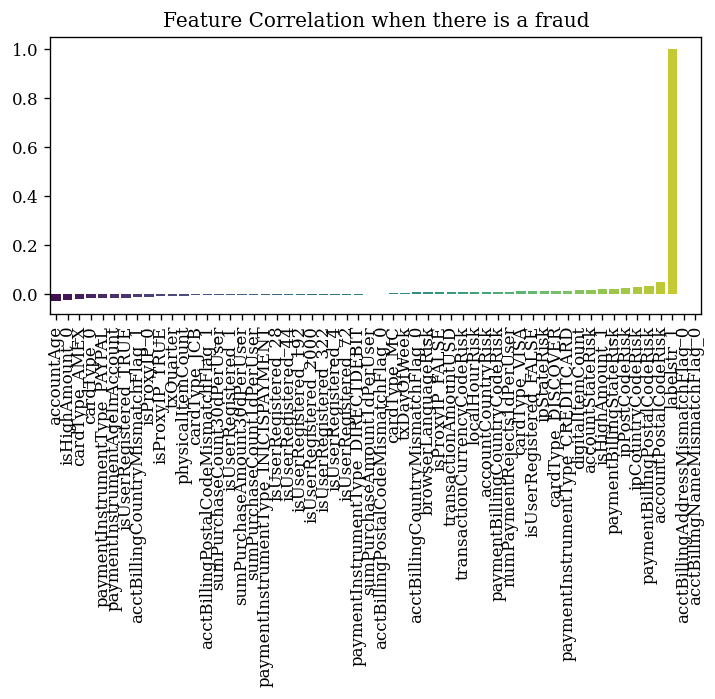

In [6]:
df_corr  = pd.get_dummies(df[['labelstr',
       'txDayOfWeek', 'txQuarter', 'transactionAmountUSD', 'digitalItemCount',
       'physicalItemCount', 'isProxyIP', 'paymentInstrumentType', 'cardType',
       'isUserRegistered', 'accountAge', 'paymentInstrumentAgeInAccount',
       'numPaymentRejects1dPerUser', 'isHighAmount',
       'acctBillingAddressMismatchFlag', 'acctBillingPostalCodeMismatchFlag',
       'acctBillingCountryMismatchFlag', 'acctBillingNameMismatchFlag',
       'acctShippingAddressMismatchFlag', 'shippingBillingAddressMismatchFlag',
       'accountCountryRisk', 'accountPostalCodeRisk', 'accountStateRisk',
       'browserLanguageRisk', 'ipCountryCodeRisk', 'ipPostCodeRisk',
       'ipStateRisk', 'localHourRisk', 'paymentBillingCountryCodeRisk',
       'paymentBillingPostalCodeRisk', 'paymentBillingStateRisk',
       'transactionCurrencyCodeRisk','sumPurchaseCount1dPerUser',
'sumPurchaseAmount1dPerUser',
'sumPurchaseCount30dPerUser',
'sumPurchaseAmount30dPerUser']]).corr()
# Feature Correlation when Churn = Yes
plt.figure(figsize=(7,3),dpi=120)
sns.barplot(x=df_corr['labelstr_1'].sort_values().iloc[1:-2].index,y=df_corr['labelstr_1'].sort_values().iloc[1:-2].values,palette='viridis')
plt.title('Feature Correlation when there is a fraud')
plt.xticks(rotation=90);

In [7]:
logReg = LogisticRegression()
randForest = RandomForestClassifier()
gbt = GBTClassifier()
lightgbm = LightGBMClassifier()

StatementMeta(, 631c94ad-beaa-4fd8-b173-b33ab627ebda, 9, Finished, Available)

In [8]:
EXPERIMENT_NAME = "fraud_automl"
TARGET_COL = "label"
smlmodels = [logReg,randForest,gbt,lightgbm]
mmlmodels = [TrainClassifier(model=model, labelCol=TARGET_COL) for model in smlmodels]

StatementMeta(, 631c94ad-beaa-4fd8-b173-b33ab627ebda, 10, Finished, Available)

In [9]:
paramBuilder = (
    HyperparamBuilder()
    .addHyperparam(logReg, logReg.regParam, RangeHyperParam(0.1, 0.3))
    .addHyperparam(randForest, randForest.numTrees, DiscreteHyperParam([5, 10]))
    .addHyperparam(randForest, randForest.maxDepth, DiscreteHyperParam([3, 5]))
    .addHyperparam(gbt, gbt.maxBins, RangeHyperParam(8, 16))
    .addHyperparam(gbt, gbt.maxDepth, DiscreteHyperParam([3, 5]))
    .addHyperparam(lightgbm, lightgbm.baggingFraction, DiscreteHyperParam([0.8,1]))
    )

StatementMeta(, 631c94ad-beaa-4fd8-b173-b33ab627ebda, 11, Finished, Available)

In [10]:
searchSpace = paramBuilder.build()
randomSpace = RandomSpace(searchSpace)

StatementMeta(, 631c94ad-beaa-4fd8-b173-b33ab627ebda, 12, Finished, Available)

In [11]:
df_clean = df[[
'label',
'labelstr'                                     ,
'txDayOfWeek'                                  ,
'transactionAmountUSD'                         ,
'digitalItemCount'                             ,
'physicalItemCount'                            ,
'accountAge'                                   ,
'paymentInstrumentAgeInAccount'                ,
'numPaymentRejects1dPerUser'                   ,
'accountCountryRisk'                           ,
'accountPostalCodeRisk'                        ,
'accountStateRisk'                             ,
'browserLanguageRisk'                          ,
'ipCountryCodeRisk'                            ,
'ipPostCodeRisk'                               ,
'ipStateRisk'                                  ,
'localHourRisk'                                ,
'paymentBillingCountryCodeRisk'                ,
'paymentBillingPostalCodeRisk'                 ,
'paymentBillingStateRisk'                      ,
'transactionCurrencyCodeRisk'                  ,
'isProxyIP'                                     ,
'paymentInstrumentType'                         ,
'cardType'                                      ,
'isUserRegistered'                              ,
'isHighAmount'                                  ,
'acctBillingAddressMismatchFlag'                ,
'acctBillingPostalCodeMismatchFlag'             ,
'acctBillingCountryMismatchFlag'                ,
'acctBillingNameMismatchFlag'                   ,
'acctShippingAddressMismatchFlag'               ,
'shippingBillingAddressMismatchFlag'        ,
'sumPurchaseCount1dPerUser',
'sumPurchaseAmount1dPerUser',
'sumPurchaseCount30dPerUser',
'sumPurchaseAmount30dPerUser'   ]]

StatementMeta(, 631c94ad-beaa-4fd8-b173-b33ab627ebda, 13, Finished, Available)

In [13]:
!pip install imblearn

StatementMeta(, 631c94ad-beaa-4fd8-b173-b33ab627ebda, 15, Finished, Available)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 15.0 MB/s eta 0:00:00


In [14]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
df_encoded  = pd.get_dummies(df[[
       'txDayOfWeek', 'txQuarter', 'transactionAmountUSD', 'digitalItemCount',
       'physicalItemCount', 'isProxyIP', 'paymentInstrumentType', 'cardType',
       'isUserRegistered', 'accountAge', 'paymentInstrumentAgeInAccount',
       'numPaymentRejects1dPerUser', 'isHighAmount',
       'acctBillingAddressMismatchFlag', 'acctBillingPostalCodeMismatchFlag',
       'acctBillingCountryMismatchFlag', 'acctBillingNameMismatchFlag',
       'acctShippingAddressMismatchFlag', 'shippingBillingAddressMismatchFlag',
       'accountCountryRisk', 'accountPostalCodeRisk', 'accountStateRisk',
       'browserLanguageRisk', 'ipCountryCodeRisk', 'ipPostCodeRisk',
       'ipStateRisk', 'localHourRisk', 'paymentBillingCountryCodeRisk',
       'paymentBillingPostalCodeRisk', 'paymentBillingStateRisk',
       'transactionCurrencyCodeRisk']])
X = df_encoded  
y = df_clean['label']
sampling_strategy = {0: 198326, 1: 20000}
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_res, y_res = smote.fit_resample(X, y)

StatementMeta(, 631c94ad-beaa-4fd8-b173-b33ab627ebda, 16, Finished, Available)

2024-01-15:01:47:09,584 WARNING  [tracking_store.py:153] log_inputs not supported


In [15]:
df_final = pd.concat([X_res, y_res], axis=1)
df_final['label'].value_counts()

StatementMeta(, 631c94ad-beaa-4fd8-b173-b33ab627ebda, 17, Finished, Available)

label
0    198326
1     20000
Name: count, dtype: int64

In [16]:
data = spark.createDataFrame(df_final)
tune, test = data.randomSplit([0.75, 0.25])

StatementMeta(, 631c94ad-beaa-4fd8-b173-b33ab627ebda, 18, Finished, Available)

In [17]:
bestModel = TuneHyperparameters(
    evaluationMetric="accuracy",
    models=mmlmodels,
    numFolds=2,
    numRuns=len(mmlmodels) * 1,
    parallelism=1,
    paramSpace=randomSpace.space(),
    seed=0,

).fit(tune)

StatementMeta(, 631c94ad-beaa-4fd8-b173-b33ab627ebda, 19, Finished, Available)

2024-01-15:01:47:48,340 WARNING  [tracking_store.py:153] log_inputs not supported


In [18]:
print(bestModel.getBestModelInfo())
print(bestModel.getBestModel())

StatementMeta(, 631c94ad-beaa-4fd8-b173-b33ab627ebda, 20, Finished, Available)

cacheNodeIds: false, checkpointInterval: 10, featureSubsetStrategy: all, featuresCol: TrainClassifier_bb696f47dee9_features, impurity: variance, labelCol: label, leafCol: , lossType: logistic, maxBins: 9, maxDepth: 3, maxIter: 20, maxMemoryInMB: 256, minInfoGain: 0.0, minInstancesPerNode: 1, minWeightFractionPerNode: 0.0, predictionCol: prediction, probabilityCol: probability, rawPredictionCol: rawPrediction, seed: 3504127614838123891, stepSize: 0.1, subsamplingRate: 1.0, validationTol: 0.01
TrainClassifierModel_68859fbe2351


In [19]:
prediction = bestModel.transform(test)
metrics = ComputeModelStatistics().transform(prediction)
metrics.limit(10).toPandas()

StatementMeta(, 631c94ad-beaa-4fd8-b173-b33ab627ebda, 21, Finished, Available)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:117: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: MatrixUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


,evaluation_type,confusion_matrix,accuracy,precision,recall,AUC
0,Classification,"DenseMatrix([[49111., 444.],\n [...",0.961498,0.880805,0.664843,0.827942


StatementMeta(, 631c94ad-beaa-4fd8-b173-b33ab627ebda, 22, Finished, Available)

[[49111.   444.]
 [ 1654.  3281.]]


Text(41.25, 0.5, 'True label')

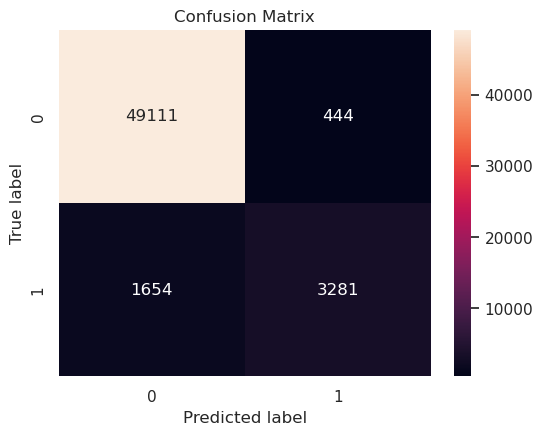

In [20]:
cm = metrics.select("confusion_matrix").collect()[0][0].toArray()
print(cm)
sns.set(rc={"figure.figsize": (6, 4.5)})
ax = sns.heatmap(cm, annot=True, fmt=".20g")
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")

In [21]:
def evaluate(predictions):
    """
    Evaluate the model by computing AUROC and AUPRC with the predictions.
    """
    # initialize the binary evaluator
    evaluator = BinaryClassificationEvaluator(
        rawPredictionCol="prediction", labelCol=TARGET_COL)
    _evaluator = lambda metric: evaluator.setMetricName(metric).evaluate(predictions)

    # calculate AUROC, baseline 0.5
    auroc = _evaluator("areaUnderROC")
    print(f"AUROC: {auroc:.4f}")
    
    # calculate AUPRC, baseline positive rate (0.172% in the demo data)
    auprc = _evaluator("areaUnderPR")
    print(f"AUPRC: {auprc:.4f}")
    return auroc, auprc

StatementMeta(, 631c94ad-beaa-4fd8-b173-b33ab627ebda, 23, Finished, Available)

In [22]:
auroc, auprc = evaluate(prediction)

StatementMeta(, 631c94ad-beaa-4fd8-b173-b33ab627ebda, 24, Finished, Available)

2024-01-15:01:58:07,8 WARNING  [tracking_store.py:153] log_inputs not supported
2024-01-15:01:58:12,383 WARNING  [tracking_store.py:153] log_inputs not supported


AUROC: 0.8279
AUPRC: 0.7484


In [24]:
df_all = df[[
'label'                                     ,
'txDayOfWeek'                                  ,
'transactionAmountUSD'                         ,
'digitalItemCount'                             ,
'physicalItemCount'                            ,
'accountAge'                                   ,
'paymentInstrumentAgeInAccount'                ,
'numPaymentRejects1dPerUser'                   ,
'accountCountryRisk'                           ,
'accountPostalCodeRisk'                        ,
'accountStateRisk'                             ,
'browserLanguageRisk'                          ,
'ipCountryCodeRisk'                            ,
'ipPostCodeRisk'                               ,
'ipStateRisk'                                  ,
'localHourRisk'                                ,
'paymentBillingCountryCodeRisk'                ,
'paymentBillingPostalCodeRisk'                 ,
'paymentBillingStateRisk'                      ,
'transactionCurrencyCodeRisk'                  ,
'isProxyIP'                                     ,
'paymentInstrumentType'                         ,
'cardType'                                      ,
'isUserRegistered'                              ,
'isHighAmount'                                  ,
'acctBillingAddressMismatchFlag'                ,
'acctBillingPostalCodeMismatchFlag'             ,
'acctBillingCountryMismatchFlag'                ,
'acctBillingNameMismatchFlag'                   ,
'acctShippingAddressMismatchFlag'               ,
'shippingBillingAddressMismatchFlag'   ,       
'sumPurchaseCount1dPerUser',
'sumPurchaseAmount1dPerUser',
'sumPurchaseCount30dPerUser',
'sumPurchaseAmount30dPerUser' ]]

StatementMeta(, 631c94ad-beaa-4fd8-b173-b33ab627ebda, 26, Finished, Available)

In [30]:
df_encoded = pd.get_dummies(df_all)
data = spark.createDataFrame(df_encoded)
print("Schema: ")
sparkdf.printSchema()

StatementMeta(, 631c94ad-beaa-4fd8-b173-b33ab627ebda, 32, Finished, Available)

Schema: 
root
 |-- label: integer (nullable = true)
 |-- txDayOfWeek: integer (nullable = true)
 |-- transactionAmountUSD: float (nullable = true)
 |-- digitalItemCount: float (nullable = true)
 |-- physicalItemCount: float (nullable = true)
 |-- accountAge: float (nullable = true)
 |-- paymentInstrumentAgeInAccount: float (nullable = true)
 |-- numPaymentRejects1dPerUser: float (nullable = true)
 |-- accountCountryRisk: float (nullable = true)
 |-- accountPostalCodeRisk: float (nullable = true)
 |-- accountStateRisk: float (nullable = true)
 |-- browserLanguageRisk: float (nullable = true)
 |-- ipCountryCodeRisk: float (nullable = true)
 |-- ipPostCodeRisk: float (nullable = true)
 |-- ipStateRisk: float (nullable = true)
 |-- localHourRisk: float (nullable = true)
 |-- paymentBillingCountryCodeRisk: float (nullable = true)
 |-- paymentBillingPostalCodeRisk: float (nullable = true)
 |-- paymentBillingStateRisk: float (nullable = true)
 |-- transactionCurrencyCodeRisk: float (nullable 

In [31]:
data.groupBy("label").count().toPandas()

StatementMeta(, 631c94ad-beaa-4fd8-b173-b33ab627ebda, 33, Finished, Available)

,label,count
0,1,1169
1,0,198326


In [32]:
train, test = data.randomSplit([0.70, 0.30], seed=1)

StatementMeta(, 631c94ad-beaa-4fd8-b173-b33ab627ebda, 34, Finished, Available)

In [33]:
from pyspark.ml.feature import VectorAssembler
feature_cols = sparkdf.columns[1:]
featurizer = VectorAssembler(inputCols=feature_cols, outputCol="features")
train_data = featurizer.transform(train)["label", "features"]
test_data = featurizer.transform(test)["label", "features"]

StatementMeta(, 631c94ad-beaa-4fd8-b173-b33ab627ebda, 35, Finished, Available)

In [43]:
from synapse.ml.lightgbm import LightGBMClassifier

model = LightGBMClassifier(
    objective="binary", featuresCol="features", labelCol="label", isUnbalance=True
)

StatementMeta(, 631c94ad-beaa-4fd8-b173-b33ab627ebda, 45, Finished, Available)

In [44]:
model = model.fit(train_data)

StatementMeta(, 631c94ad-beaa-4fd8-b173-b33ab627ebda, 46, Finished, Available)

2024-01-15:02:04:33,678 WARNING  [tracking_store.py:153] log_inputs not supported


StatementMeta(, 631c94ad-beaa-4fd8-b173-b33ab627ebda, 47, Finished, Available)

f_index: Index(['paymentInstrumentType_DIRECTDEBIT',
       'acctShippingAddressMismatchFlag_0',
       'paymentInstrumentType_INICISPAYMENT', 'cardType_0', 'cardType_JCB',
       'isUserRegistered_1', 'isUserRegistered_192', 'isUserRegistered_2000',
       'isUserRegistered_28', 'paymentInstrumentType_CREDITCARD',
       'isUserRegistered_322', 'isUserRegistered_44', 'isUserRegistered_72',
       'isUserRegistered_FALSE', 'isHighAmount_1',
       'acctBillingAddressMismatchFlag_0',
       'acctBillingPostalCodeMismatchFlag_0',
       'acctBillingCountryMismatchFlag_0', 'acctBillingNameMismatchFlag_0',
       'isUserRegistered_4', 'isProxyIP_FALSE',
       'shippingBillingAddressMismatchFlag_0',
       'acctBillingCountryMismatchFlag_1', 'isHighAmount_0', 'isProxyIP_0',
       'numPaymentRejects1dPerUser', 'cardType_DISCOVER',
       'isUserRegistered_TRUE', 'paymentInstrumentType_PAYPAL',
       'sumPurchaseCount30dPerUser', 'isProxyIP_TRUE',
       'sumPurchaseCount1dPerUser', 'digit

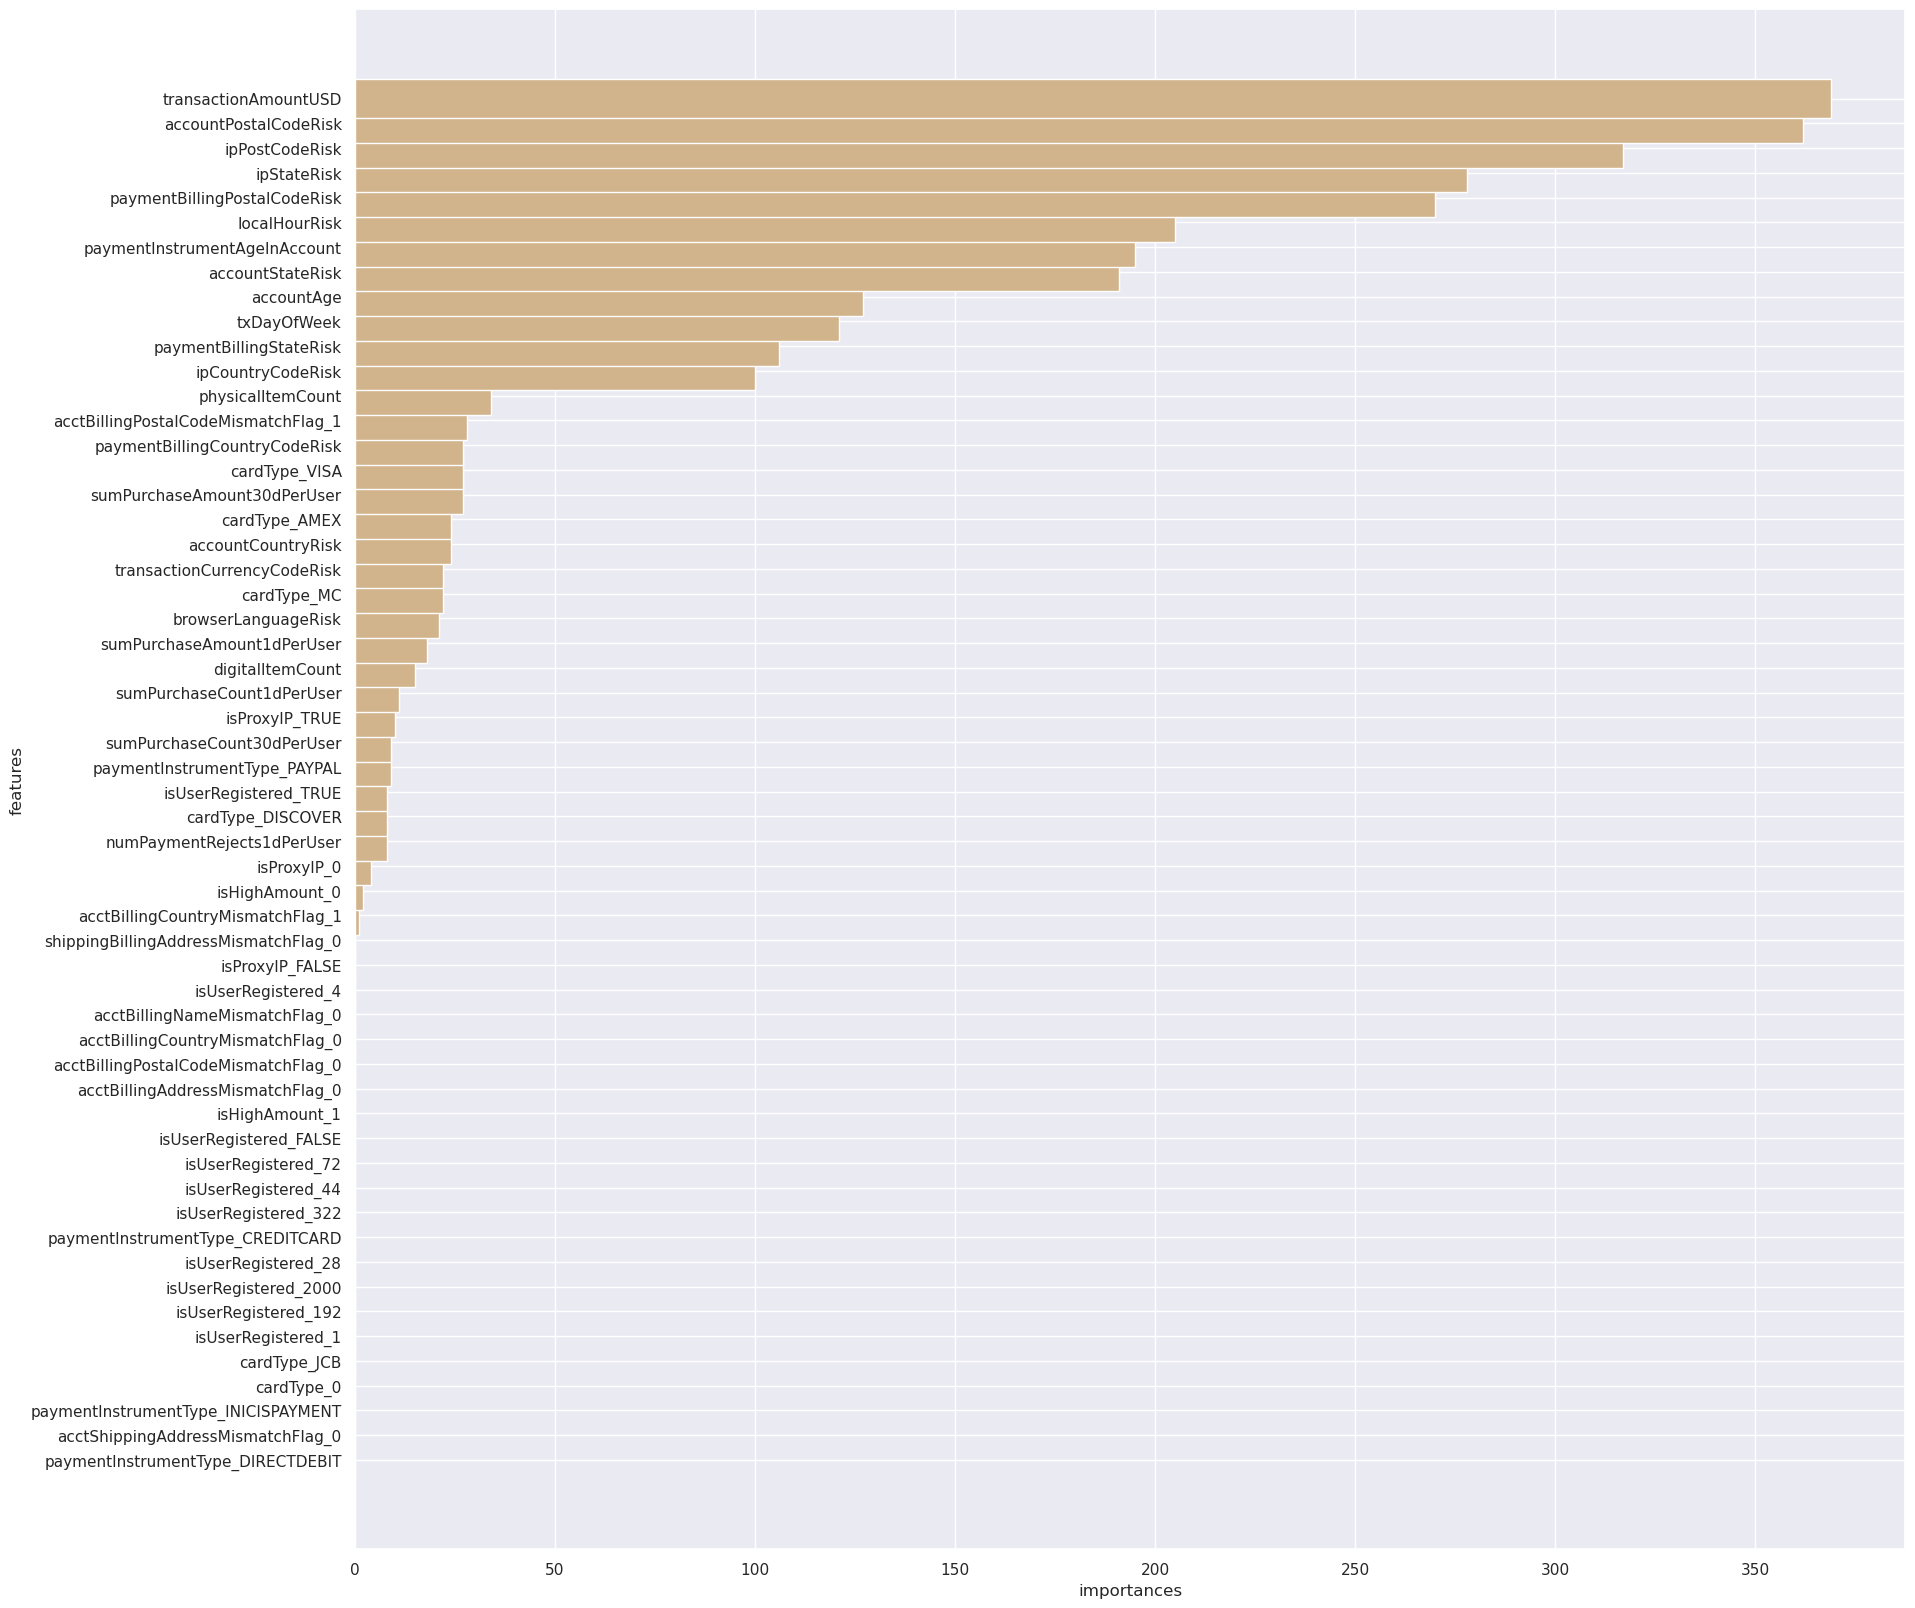

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

feature_importances = model.getFeatureImportances()
fi = pd.Series(feature_importances, index=feature_cols)
fi = fi.sort_values(ascending=True)
f_index = fi.index
f_values = fi.values

# print feature importances
print("f_index:", f_index)
print("f_values:", f_values)

# plot
x_index = list(range(len(fi)))
x_index = [x / len(fi) for x in x_index]
plt.rcParams["figure.figsize"] = (20, 20)
plt.barh(
    x_index, f_values, height=0.028, align="center", color="tan", tick_label=f_index
)
plt.xlabel("importances")
plt.ylabel("features")
plt.show()

In [46]:
predictions = model.transform(test_data)
predictions.limit(10).toPandas()

StatementMeta(, 631c94ad-beaa-4fd8-b173-b33ab627ebda, 48, Finished, Available)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:117: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


,label,features,rawPrediction,probability,prediction
0,0,"(1.0, 0.0, 1.0, 0.0, 453.0, 452.3847351074219,...","[6.149409825198178, -6.149409825198178]","[0.9978698061438911, 0.00213019385610893]",0.0
1,0,"(1.0, 0.0, 1.0, 0.0, 481.0, 480.6625061035156,...","[6.759624413833945, -6.759624413833945]","[0.9988416786182361, 0.0011583213817638717]",0.0
2,0,"(1.0, 0.0, 1.0, 0.0, 831.0, 0.0062500000931322...","[930968.6323290713, -930968.6323290713]","[1.0, 0.0]",0.0
3,0,"(1.0, 0.0, 1.0, 0.0, 946.0, 945.8632202148438,...","[8.169161675748937, -8.169161675748937]","[0.9997168248340987, 0.00028317516590123756]",0.0
4,0,"(1.0, 0.0, 1.0, 0.0, 1098.0, 57.12430572509765...","[122739.93019586218, -122739.93019586218]","[1.0, 0.0]",0.0
5,0,"(1.0, 0.0, 1.0, 0.0, 1219.0, 0.000694443995598...","[7.496077357325975, -7.496077357325975]","[0.9994450499572933, 0.000554950042706643]",0.0
6,0,"(1.0, 0.0, 1.0, 0.0, 1239.0, 693.48681640625, ...","[5.913424033953291, -5.913424033953291]","[0.9973043699139718, 0.002695630086028218]",0.0
7,0,"(1.0, 0.0, 1.0, 0.0, 1881.0, 12.39861106872558...","[9.503132186708557, -9.503132186708557]","[0.9999253878206243, 7.461217937570065e-05]",0.0
8,0,"(1.0, 0.0, 1.0, 0.0, 1967.0, 367.2701416015625...","[12.132771914190004, -12.132771914190004]","[0.9999946197584899, 5.380241510094489e-06]",0.0
9,0,"(1.0, 0.15000000596046448, 1.0, 0.0, 3.0, 2.02...","[2.0066731089351055, -2.0066731089351055]","[0.8814959331562501, 0.11850406684374988]",0.0


In [47]:
from synapse.ml.train import ComputeModelStatistics

metrics = ComputeModelStatistics(
    evaluationMetric="classification",
    labelCol="label",
    scoredLabelsCol="prediction",
).transform(predictions)
metrics.toPandas()

StatementMeta(, 631c94ad-beaa-4fd8-b173-b33ab627ebda, 49, Finished, Available)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:117: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: MatrixUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


,evaluation_type,confusion_matrix,accuracy,precision,recall,AUC
0,Classification,"DenseMatrix([[55466., 3772.],\n [...",0.934663,0.066105,0.682864,0.809595


StatementMeta(, 631c94ad-beaa-4fd8-b173-b33ab627ebda, 50, Finished, Available)

[[55466.  3772.]
 [  124.   267.]]


Text(41.25, 0.5, 'True label')

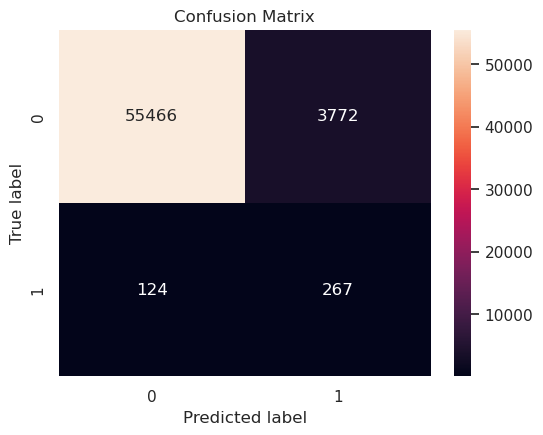

In [48]:
cm = metrics.select("confusion_matrix").collect()[0][0].toArray()
print(cm)
sns.set(rc={"figure.figsize": (6, 4.5)})
ax = sns.heatmap(cm, annot=True, fmt=".20g")
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")

In [49]:
MODEL_NAME = "fabricfraudmodel"
EXPERIMENT_NAME = "fraud_fabricml"
TARGET_COL="label"

StatementMeta(, 631c94ad-beaa-4fd8-b173-b33ab627ebda, 51, Finished, Available)

In [50]:
def evaluate(predictions):
    """
    Evaluate the model by computing AUROC and AUPRC with the predictions.
    """
    # initialize the binary evaluator
    evaluator = BinaryClassificationEvaluator(
        rawPredictionCol="prediction", labelCol=TARGET_COL)
    _evaluator = lambda metric: evaluator.setMetricName(metric).evaluate(predictions)

    # calculate AUROC, baseline 0.5
    auroc = _evaluator("areaUnderROC")
    print(f"AUROC: {auroc:.4f}")
    
    # calculate AUPRC, baseline positive rate (0.172% in the demo data)
    auprc = _evaluator("areaUnderPR")
    print(f"AUPRC: {auprc:.4f}")
    return auroc, auprc

StatementMeta(, 631c94ad-beaa-4fd8-b173-b33ab627ebda, 52, Finished, Available)

In [51]:
auroc, auprc = evaluate(predictions)

StatementMeta(, 631c94ad-beaa-4fd8-b173-b33ab627ebda, 53, Finished, Available)

2024-01-15:02:06:06,119 WARNING  [tracking_store.py:153] log_inputs not supported
2024-01-15:02:06:12,654 WARNING  [tracking_store.py:153] log_inputs not supported


AUROC: 0.8096
AUPRC: 0.0567
